In [1]:
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import matplotlib as mpl
import pandas as pd
from IPython.display import clear_output
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from time import time
from copy import copy
from typing import List
from qc_grader.utilities.graph_util import display_maxcut_widget, QAOA_widget, graphs
from qiskit.circuit import Parameter, ParameterVector
mpl.rcParams['figure.dpi'] = 300

/var/folders/ty/83td_vqx6p358xs9hrgr1x600000gn/T/ipykernel_29602/4076105552.py:12: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM


## Classical Quadratic Binary Optimization

In [2]:
graph = nx.Graph()
#Add nodes and edges
graph.add_nodes_from(np.arange(0,6,1))
edges = [(0,1,2.0),(0,2,3.0),(0,3,2.0),(0,4,4.0),(0,5,1.0),(1,2,4.0),(1,3,1.0),(1,4,1.0),(1,5,3.0),(2,4,2.0),(2,5,3.0),(3,4,5.0),(3,5,1.0)]
graph.add_weighted_edges_from(edges)
graphs['custom'] = graph
#Display widget
display_maxcut_widget(graphs['custom'])

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

Output()

In [3]:
def maxcut_cost_fn(graph: nx.Graph, bitstring: List[int]) -> float:
    """
    Computes the maxcut cost function value for a given graph and cut represented by some bitstring
    Args:
        graph: The graph to compute cut values for
        bitstring: A list of integer values '0' or '1' specifying a cut of the graph
    Returns:
        The value of the cut
    """
    #Get the weight matrix of the graph
    weight_matrix = nx.adjacency_matrix(graph).toarray()
    size = weight_matrix.shape[0]
    value = 0.

    #INSERT YOUR CODE TO COMPUTE THE CUT VALUE HERE

    for i in range(size):
        for j in range(size):
            value = (value + (weight_matrix[i,j] * bitstring[i] * (1 - bitstring[j])))

    return value

In [4]:
def plot_maxcut_histogram(graph: nx.Graph) -> None:
    """
    Plots a bar diagram with the values for all possible cuts of a given graph.
    Args:
        graph: The graph to compute cut values for
    """
    num_vars = graph.number_of_nodes()
    #Create list of bitstrings and corresponding cut values
    bitstrings = ['{:b}'.format(i).rjust(num_vars, '0')[::-1] for i in range(2**num_vars)]
    values = [maxcut_cost_fn(graph = graph, bitstring = [int(x) for x in bitstring]) for bitstring in bitstrings]
    #Sort both lists by largest cut value
    values, bitstrings = zip(*sorted(zip(values, bitstrings)))
    #Plot bar diagram
    bar_plot = go.Bar(x = bitstrings, y = values, marker=dict(color=values, colorscale = 'plasma', colorbar=dict(title='Cut Value')))
    fig = go.Figure(data=bar_plot, layout = dict(xaxis=dict(type = 'category'), width = 1500, height = 600))
    fig.show()

In [5]:
import nbformat

plot_maxcut_histogram(graph = graphs['custom'])

## Quantum Quadratic Binary Optimization (1)

In [6]:
def quadratic_info_from_graph(graph: nx.Graph):
    """Constructs a quadratic program from a given graph for a MaxCut problem instance.
    Args:
        graph: Underlying graph of the problem.
    Returns:
        QuadraticProgram
    """
    #Get weight matrix of graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    #Build qubo matrix Q and qubo vector C from weight matrix W
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    for i in range(size):
        for j in range(size):
            qubo_matrix[i, j] -= weight_matrix[i, j]
    for i in range(size):
        for j in range(size):
            qubo_vector[i] += weight_matrix[i,j]
    
    return {'quadratic': qubo_matrix, 'linear': qubo_vector}

## Hard-Coded QUBO Problem to QAOA Circuit

In [7]:
def qaoa_circuit(qubo, p: int = 1):
    """
    Given a QUBO instance and the number of layers p, constructs the corresponding parameterized QAOA circuit with p layers.
    Args:
        qubo: The quadratic program instance
        p: The number of layers in the QAOA circuit
    Returns:
        The parameterized QAOA circuit
    """
    size = len(qubo['linear'])
    qubo_matrix = qubo['quadratic']
    qubo_matrix = (qubo_matrix + qubo_matrix.T)/2
    qubo_linearity = qubo['linear']

    #Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size,size)
    #Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    #Create the parameters to be used in the circuit
    gammas = ParameterVector('gamma', p)
    betas = ParameterVector('beta', p)

    #Outer loop to create each layer
    for i in range(p):

        #Apply R_Z rotational gates from cost layer
        #INSERT YOUR CODE HERE
        for j in range(size):
            qubo_matrix_sum = 0
            for k in range(size):
                qubo_matrix_sum += qubo_matrix[j][k]
            qaoa_circuit.rz((qubo_linearity[j] + qubo_matrix_sum)*gammas[i],j)

        #Apply R_ZZ rotational gates for entangled qubit rotations from cost layer
        #INSERT YOUR CODE HERE
        for j in range(size):
            for k in range(j+1,size):
                qaoa_circuit.rzz(0.5*qubo_matrix[j][k], j, k)
                        
        # Apply single qubit X - rotations with angle 2*beta_i to all qubits
        #INSERT YOUR CODE HERE
        qaoa_circuit.rx(2*betas[i],range(size))

    return qaoa_circuit

In [8]:
quadratic_info = quadratic_info_from_graph(graphs['custom'])
custom_circuit = qaoa_circuit(qubo = quadratic_info)

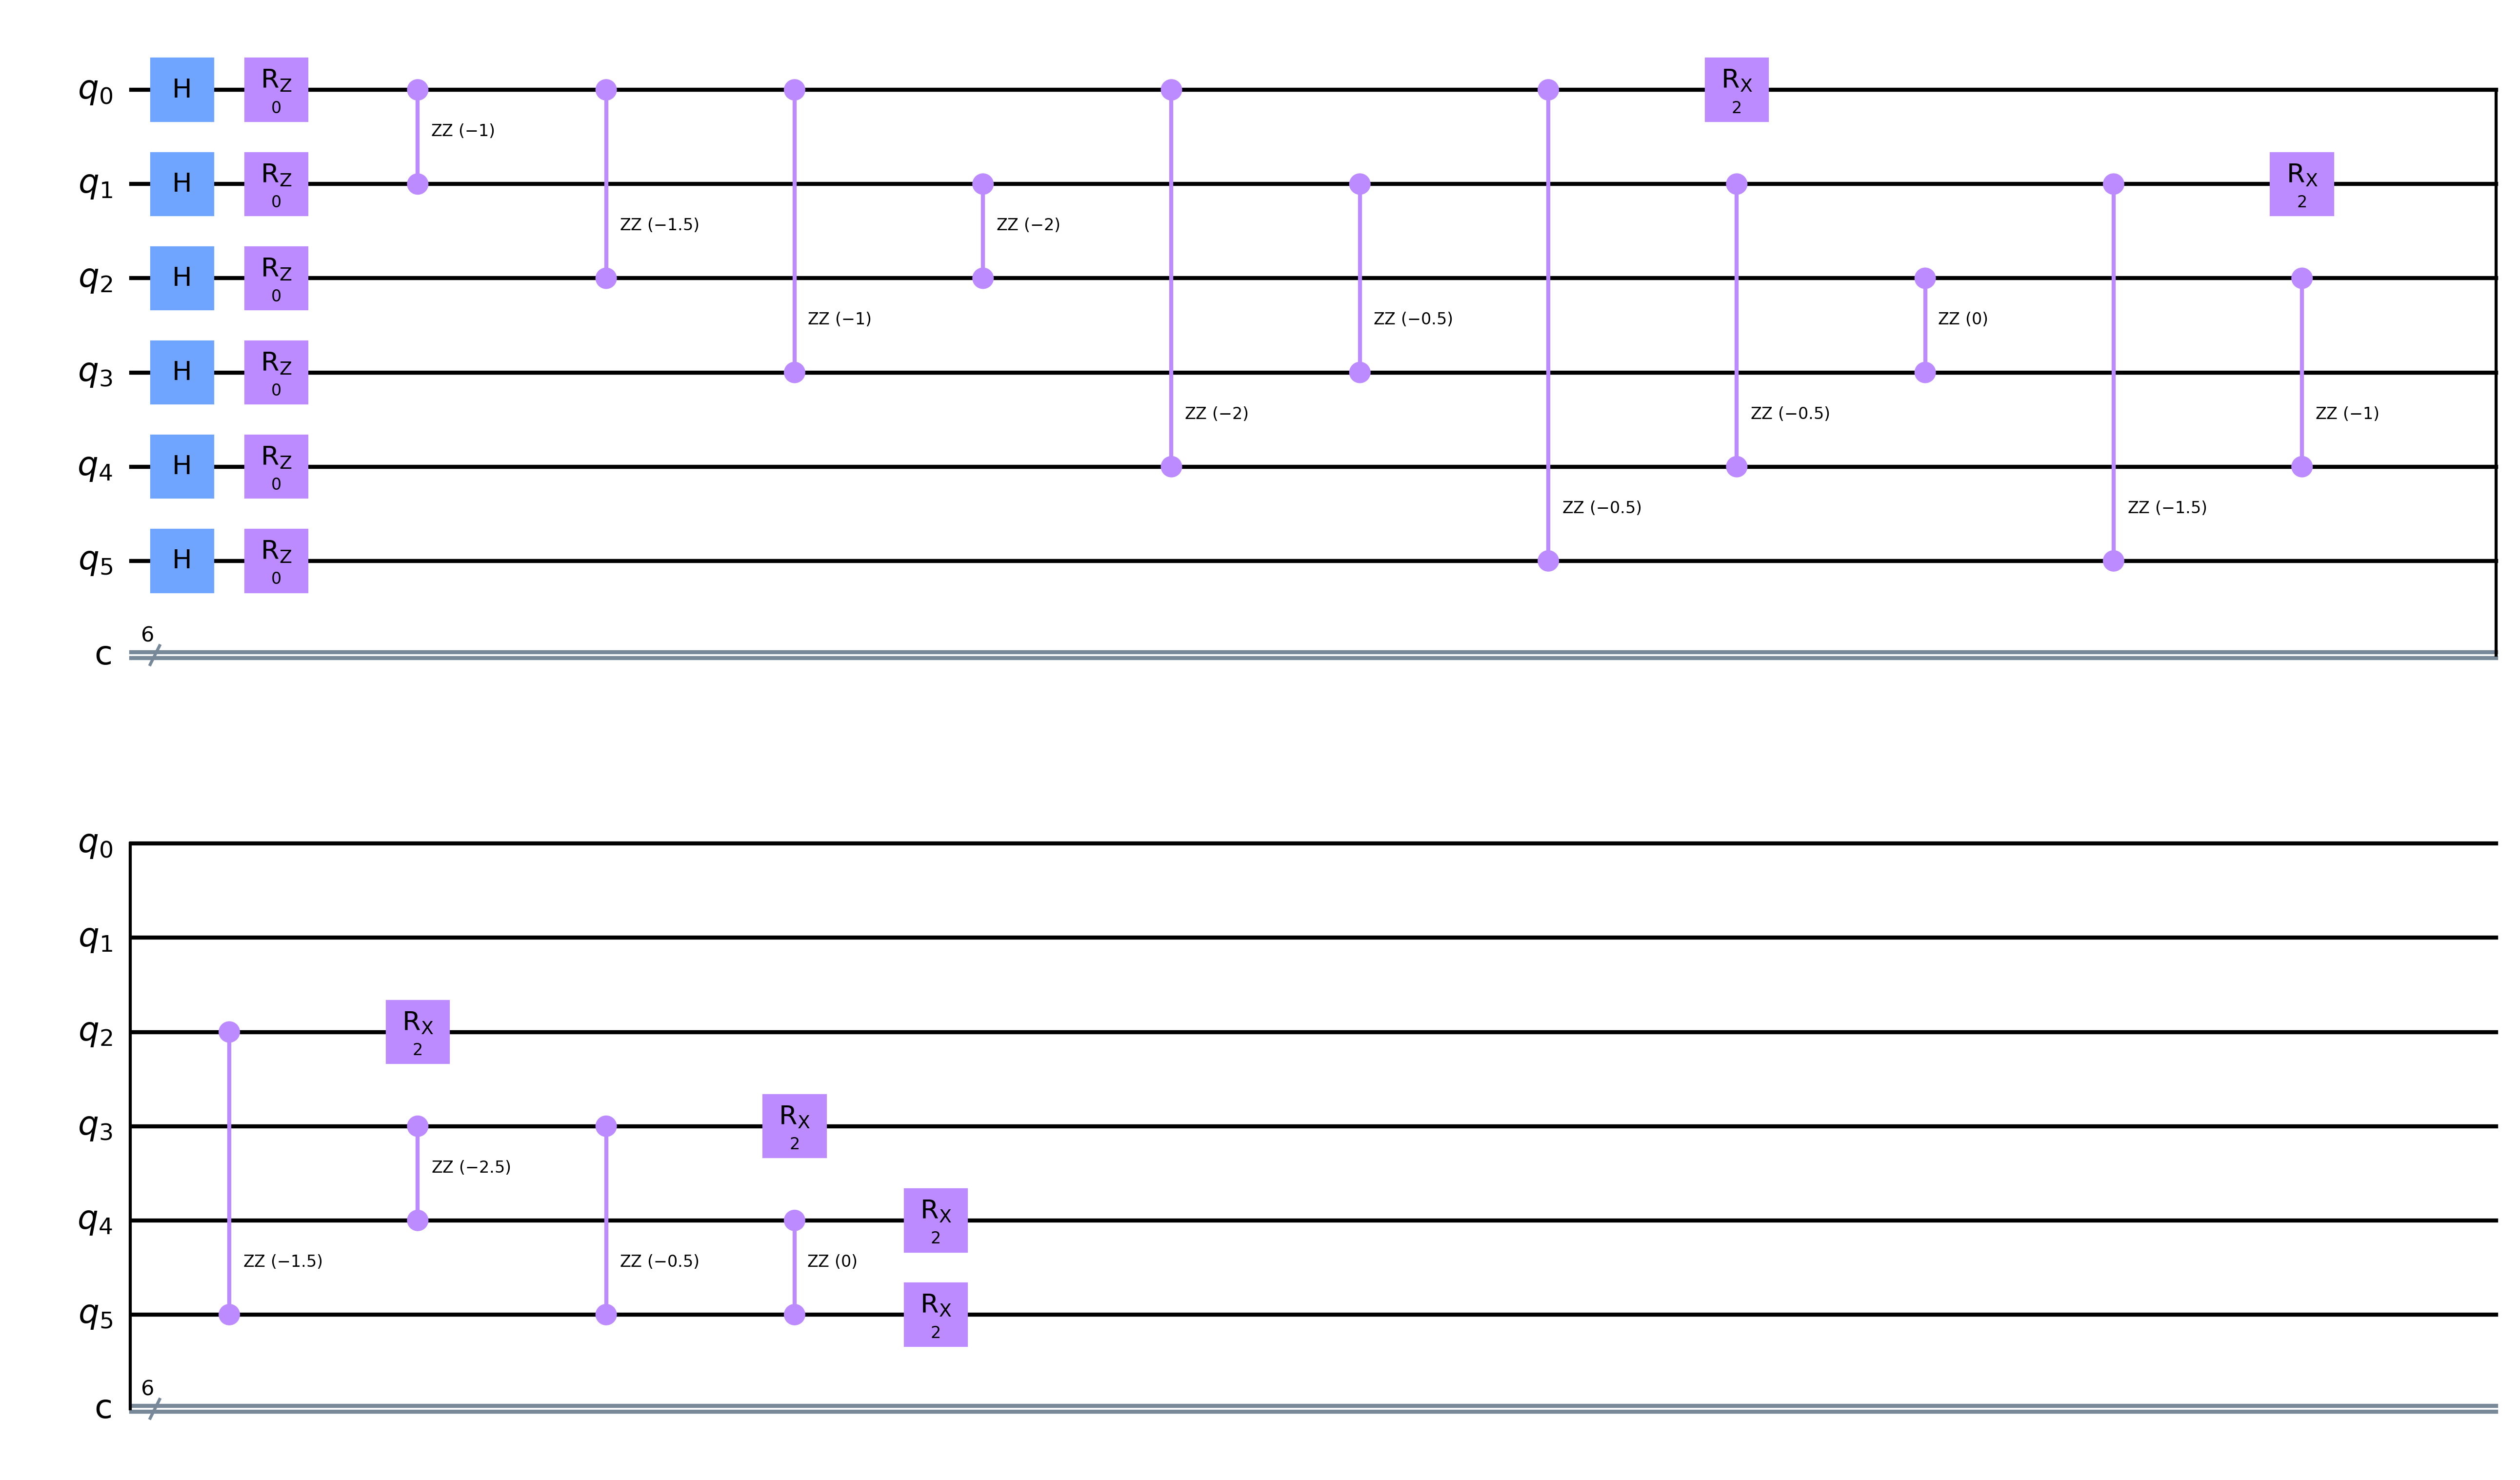

In [9]:
test = custom_circuit.assign_parameters(parameters=[1.0]*len(custom_circuit.parameters))
test.draw('mpl')

## Quantum Quadratic Binary Optimization (2)

In [10]:
def get_hamiltonian_linop(qubo):
    size = len(qubo['linear'])
    qubo_matrix = qubo['quadratic']
    qubo_matrix = (qubo_matrix + qubo_matrix.T)/2
    qubo_linearity = qubo['linear']

    linop = []

    for i in range(size):
        for j in range(i+1,size):
            gate_list = ['I' for _ in range(size)]
            gate_list[i] = 'Z'
            gate_list[j] = 'Z'
            gate_str = ''.join(gate_list)
            coeff = 0.5*qubo_matrix[i][j]
            linop.append((gate_str,coeff))

    for i in range(size):
        qubo_matrix_sum = 0
        for j in range(size):
            qubo_matrix_sum += qubo_matrix[i][j]
        gate_list = ['I' for _ in range(size)]
        gate_list[i] = 'Z'
        gate_str = ''.join(gate_list)
        coeff = -1*0.5*(qubo_linearity[i] + qubo_matrix_sum)
        linop.append((gate_str,coeff))

    id_gate_list = ['I' for _ in range(size)]
    id_gate_str = ''.join(id_gate_list)
    id_coeff = 0
    for i in range(size):
        for j in range(size):
            id_coeff += 0.25*qubo_matrix[i][j]
        id_coeff += 0.5*qubo_linearity[i]
    linop.append((id_gate_str,id_coeff))

    return linop

In [11]:
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.opflow import PauliSumOp 
from qiskit.quantum_info import SparsePauliOp 

hamiltonian = PauliSumOp(SparsePauliOp.from_list(get_hamiltonian_linop(quadratic_info)))

backend = Aer.get_backend('statevector_simulator')
qaoa = QAOA(sampler=backend, optimizer=ADAM(), reps=1, initial_point = [0.1,0.1])
result = qaoa.compute_minimum_eigenvalue(operator=hamiltonian)
eigenvalue = result.eigenvalue

TypeError: bad input to run() function;`validation` argument is only effective for input qobj